In [1]:
import os
os.environ['LDFLAGS'] = "-L/opt/homebrew/opt/libomp/lib"
os.environ['CPPFLAGS'] = "-I/opt/homebrew/opt/libomp/include"
# !pip3 install cmake
# !pip3 install --no-cache-dir lightgbm
# !pip3 install lightgbm

In [2]:
# %pip install implicit

In [3]:
# !pip3 install pandas numpy seaborn matplotlib lightgbm tqdm pickle5
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb

import pickle
from tqdm import tqdm
import gc
from pathlib import Path

In [4]:
import warnings
import sys
from IPython.core.interactiveshell import InteractiveShell
import os

warnings.filterwarnings("ignore")
sys.path.append("/Users/tuanthanh/Documents/KLTN/SourceClone/H-M-Fashion-RecSys/") # path to the `src`` folder
InteractiveShell.ast_node_interactivity = "all"
tqdm.pandas()

In [5]:
from src.data import DataHelper
# from src.data import DataHelper_Vibrent
from src.data.metrics_VB import map_at_k, hr_at_k, recall_at_k

from src.retrieval.rules_Vibrent import (
    OrderHistory,
    OrderHistoryDecay,
    ItemPair,
    UserGroupTimeHistory,
    UserGroupSaleTrend,
    TimeHistory,
    TimeHistoryDecay,
    OutOfStock,

    # ------------
    ItemCF,
    UserGroupItemCF
)
from src.retrieval.collector import RuleCollector

from src.features import full_sale, week_sale, repurchase_ratio, popularity, period_sale

from src.utils_VB import (
    calc_valid_date,
    merge_week_data,
    reduce_mem_usage,
    calc_embd_similarity,
)

In [6]:
data_dir = Path("/Users/tuanthanh/Documents/KLTN/SourceClone/H-M-Fashion-RecSys/data/Vibrent")
model_dir = Path("/Users/tuanthanh/Documents/KLTN/SourceClone/H-M-Fashion-RecSys/models/models_Vibrent")
# data_dir = Path("/Users/tuanthanh/Documents/KLTN/SourceClone/H-M-Fashion-RecSys/data/HM")
# model_dir = Path("/Users/tuanthanh/Documents/KLTN/SourceClone/H-M-Fashion-RecSys/models/models_HM")

In [7]:
TRAIN_WEEK_NUM = 4
WEEK_NUM = TRAIN_WEEK_NUM + 2

VERSION_NAME = "Recall 1"
TEST = True # * Set as `False` when do local experiments to save time

In [8]:
import os
if not os.path.exists(data_dir/"interim"/VERSION_NAME):
    os.mkdir(data_dir/"interim"/VERSION_NAME)
if not os.path.exists(data_dir/"processed"/VERSION_NAME):
    os.mkdir(data_dir/"processed"/VERSION_NAME)

Pepare data: encoding ids and preprocessing

In [9]:
dh = DataHelper(data_dir)

## Retrieval


In [10]:
# data = dh.preprocess_data(save=True, name="encoded_full") # * run only once, processed data will be saved

In [11]:
data = dh.load_data(name="encoded_full")

In [12]:
uid2idx = pickle.load(open(data_dir/"index_id_map/user_id2index.pkl", "rb"))
submission = pd.read_csv(data_dir/"raw"/'sample_submission.csv')
submission['customer_id'] = submission['customer_id'].map(uid2idx)

Generate candidates for each week

In [13]:
listBin = [-1, 19, 29, 39, 49, 59, 69, 119]
data['user']['age_bins'] = pd.cut(data['user']['age'], listBin)

In [14]:
# * WEEK_NUM = 0: test
# * WEEK_NUM = 1: valid
# * WEEK_NUM > 1: train
for week in range(1,WEEK_NUM):
    # * use sliding window to generate candidates
    if week == 0 and not TEST:
        continue
    trans = data["inter"]

    start_date, end_date = calc_valid_date(week)
    print(f"Week {week}: [{start_date}, {end_date})")
    
    train, valid = dh.split_data(trans, start_date, end_date)
    train = train.merge(data['user'][['customer_id','age_bins']], on='customer_id', how='left')

    last_week_start = pd.to_datetime(start_date) - pd.Timedelta(days=7)
    last_week_start = last_week_start.strftime("%Y-%m-%d")
    last_week = train.loc[train.t_dat >= last_week_start]
    
    last_3day_start = pd.to_datetime(start_date) - pd.Timedelta(days=3)
    last_3day_start = last_3day_start.strftime("%Y-%m-%d")
    last_3days = train.loc[train.t_dat >= last_3day_start]
    

    if week != 0:
        customer_list = valid["customer_id"].values
    else:
        customer_list = submission['customer_id'].values

    # * ========================== Retrieval Strategies ==========================

    candidates = RuleCollector().collect(
        week_num = week,
        trans_df = trans,
        customer_list=customer_list,
        rules=[
            OrderHistory(train, days=3, name='1'),
            OrderHistory(train, days=7, name='2'),
            OrderHistoryDecay(train, days=3, n=50, name='1'),
            OrderHistoryDecay(train, days=7, n=50, name='2'),
            ItemPair(OrderHistory(train, days=3).retrieve(), name='1'),
            ItemPair(OrderHistory(train, days=7).retrieve(), name='2'),
            ItemPair(OrderHistoryDecay(train, days=3, n=50).retrieve(), name='3'),
            # ItemPair(OrderHistoryDecay(train, days=7, n=50).retrieve(), name='4'),
            UserGroupTimeHistory(data, customer_list, last_week, ['age_bins'], n=50, name='1'),
            UserGroupTimeHistory(data, customer_list, last_3days, ['age_bins'], n=50, name='2'),
        
            UserGroupSaleTrend(data, customer_list, train, ['age_bins'], days=7, n=50),
            TimeHistory(customer_list, last_week, n=50, name='1'),
            TimeHistory(customer_list, last_3days, n=50, name='2'),
            TimeHistoryDecay(customer_list, train, days=3, n=50, name='1'),
            TimeHistoryDecay(customer_list, train, days=7, n=50, name='2'),
            #########
        
            OrderHistory(train, days=35, n=50),
            OrderHistoryDecay(train, days=7, n=50),
            TimeHistory(customer_list, last_week, n=50),
            
        ],
        filters=[OutOfStock(trans)],
        min_pos_rate=0.0001,
        # min_pos_rate=0.007,
        compress=False,
    )

    # candidates = (
    #     pd.pivot_table(
    #         candidates,
    #         values="score",
    #         index=["customer_id", "article_id"],
    #         columns=["method"],
    #         aggfunc=np.sum,
    #     )
    #     .reset_index()
    # )
    if candidates is not None and not candidates.empty:
        candidates = (
            pd.pivot_table(
                candidates,
                values="score",
                index=["customer_id", "article_id"],
                columns=["method"],
                aggfunc=np.sum,
            ).reset_index()
        )
    else:
        print(f"⚠️ Không có ứng viên nào ở tuần {week}. Tạo DataFrame trống.")
    # candidates = pd.DataFrame(columns=["customer_id", "article_id"])


    candidates.to_parquet(data_dir/"interim"/VERSION_NAME/f"week{week}_candidate.pqt")
    valid.to_parquet(data_dir/"processed"/VERSION_NAME/f"week{week}_label.pqt")

Week 1: [2023-10-17, 2023-10-24)


Retrieve items by rules:   0%|          | 0/17 [00:00<?, ?it/s]

Positive rate: 0.17895
Positive rate: 0.20408
skip


Retrieve items by rules:  24%|██▎       | 4/17 [00:00<00:00, 38.50it/s]

Positive rate: 0.02273
Positive rate: 0.08219
Positive rate: 0.13924
skip
skip
skip
skip
skip
skip


Retrieve items by rules:  76%|███████▋  | 13/17 [00:00<00:00, 57.40it/s]

skip
skip
Positive rate: 0.12887


Retrieve items by rules: 100%|██████████| 17/17 [00:00<00:00, 50.95it/s]

Positive rate: 0.02273
skip
Week 2: [2023-10-10, 2023-10-17)



Retrieve items by rules:  24%|██▎       | 4/17 [00:00<00:00, 37.43it/s]

Positive rate: 0.18605
Positive rate: 0.17582
skip
skip
Positive rate: 0.12162
Positive rate: 0.12500
skip
skip
skip
skip
skip
skip


Retrieve items by rules: 100%|██████████| 17/17 [00:00<00:00, 51.21it/s]

skip
skip
Positive rate: 0.12727
skip
skip
Week 3: [2023-10-03, 2023-10-10)



Retrieve items by rules:  24%|██▎       | 4/17 [00:00<00:00, 38.89it/s]

Positive rate: 0.12245
Positive rate: 0.12245
skip
skip
Positive rate: 0.09859
Positive rate: 0.07595
skip
skip
skip
skip
skip
skip


Retrieve items by rules: 100%|██████████| 17/17 [00:00<00:00, 50.83it/s]

skip
skip
Positive rate: 0.07065
skip
skip
Week 4: [2023-09-26, 2023-10-03)



Retrieve items by rules:  29%|██▉       | 5/17 [00:00<00:00, 47.99it/s]

Positive rate: 0.06818
Positive rate: 0.09375
skip
Positive rate: 0.04762
Positive rate: 0.05714
Positive rate: 0.04938
skip
skip
skip
skip
skip
skip
skip


Retrieve items by rules: 100%|██████████| 17/17 [00:00<00:00, 58.93it/s]


skip
Positive rate: 0.11220
Positive rate: 0.04762
skip
Week 5: [2023-09-19, 2023-09-26)


Retrieve items by rules:   0%|          | 0/17 [00:00<?, ?it/s]

Positive rate: 0.44915
Positive rate: 0.43443


Retrieve items by rules:  29%|██▉       | 5/17 [00:00<00:00, 46.24it/s]

skip
skip
Positive rate: 0.28889
Positive rate: 0.23762
skip
skip
skip
skip
skip
skip
skip


Retrieve items by rules:  82%|████████▏ | 14/17 [00:00<00:00, 61.40it/s]

skip
Positive rate: 0.29630


Retrieve items by rules: 100%|██████████| 17/17 [00:00<00:00, 57.45it/s]

skip
skip


In [15]:
if TEST:
    week = 0
    trans = data["inter"]
    
    start_date, end_date = calc_valid_date(week)
    print(f"Week {week}: [{start_date}, {end_date})")
    
    train, valid = dh.split_data(trans, start_date, end_date)
    train = train.merge(data['user'][['customer_id','age_bins']], on='customer_id', how='left')

    last_week_start = pd.to_datetime(start_date) - pd.Timedelta(days=7)
    last_week_start = last_week_start.strftime("%Y-%m-%d")
    last_week = train.loc[train.t_dat >= last_week_start]
    
    last_3day_start = pd.to_datetime(start_date) - pd.Timedelta(days=3)
    last_3day_start = last_3day_start.strftime("%Y-%m-%d")
    last_3days = train.loc[train.t_dat >= last_3day_start]

    customer_list = submission['customer_id'].values

    # * ========================== Retrieval Strategies ==========================

    candidates = RuleCollector().collect(
        week_num = week,
        trans_df = trans,
        customer_list=customer_list,
        rules=[
            OrderHistory(train, days=3, name='1'),
            OrderHistory(train, days=7, name='2'),
            OrderHistoryDecay(train, days=3, n=50, name='1'),
            OrderHistoryDecay(train, days=7, n=50, name='2'),
            ItemPair(OrderHistory(train, days=3).retrieve(), name='1'),
            ItemPair(OrderHistory(train, days=7).retrieve(), name='2'),
            ItemPair(OrderHistoryDecay(train, 3, n=50).retrieve(), name='3'),
            # ItemPair(OrderHistoryDecay(train, 7, n=50).retrieve(), name='4'),
            UserGroupTimeHistory(data, customer_list, last_week, ['age_bins'], n=15, name='1'),
            UserGroupTimeHistory(data, customer_list, last_3days, ['age_bins'], n=20.5, name='2'),
            UserGroupSaleTrend(data, customer_list, train, ['age_bins'], days=7, n=2),
            TimeHistory(customer_list, last_week, n=9, name='1'),
            TimeHistory(customer_list, last_3days, n=16, name='2'),
            TimeHistoryDecay(customer_list, train, days=3, n=12, name='1'),
            TimeHistoryDecay(customer_list, train, days=7, n=8, name='2'),
            # SaleTrend(customer_list, train, days=7, n=2),
            OrderHistory(train, days=35, n=50),
            OrderHistoryDecay(train, days=7, n=50),
            TimeHistory(customer_list, last_week, n=50),
        ],
        filters=[OutOfStock(trans)],
        min_pos_rate=0.0001,
        compress=False,
    )
    
    candidates, _ = reduce_mem_usage(candidates)
    # candidates = (
    #     pd.pivot_table(
    #         candidates,
    #         values="score",
    #         index=["customer_id", "article_id"],
    #         columns=["method"],
    #         aggfunc=np.sum,
    #     )
    #     .reset_index()
    # )
    if candidates is not None and not candidates.empty:
        candidates = (
            pd.pivot_table(
                candidates,
                values="score",
                index=["customer_id", "article_id"],
                columns=["method"],
                aggfunc=np.sum,
            ).reset_index()
        )
    else:
        print(f"⚠️ Không có ứng viên nào ở tuần {week}. Tạo DataFrame trống.")
    # candidates = pd.DataFrame(columns=["customer_id", "article_id"])
    

    candidates.to_parquet(data_dir/"interim"/VERSION_NAME/f"week{week}_candidate.pqt")
    valid.to_parquet(data_dir/"processed"/VERSION_NAME/f"week{week}_label.pqt")

Week 0: [2023-10-24, 2023-10-31)


Retrieve items by rules:   0%|          | 0/17 [00:00<?, ?it/s]

Positive rate: 0.20000
Positive rate: 0.19767
skip


Retrieve items by rules:  24%|██▎       | 4/17 [00:00<00:00, 37.22it/s]

Positive rate: 0.03704
Positive rate: 0.10959
Positive rate: 0.10667
skip
Positive rate: nan


Retrieve items by rules:  47%|████▋     | 8/17 [00:01<00:01,  6.49it/s]

Positive rate: nan
Positive rate: nan


Retrieve items by rules:  59%|█████▉    | 10/17 [00:03<00:02,  2.53it/s]

Positive rate: nan
Positive rate: nan


Retrieve items by rules:  71%|███████   | 12/17 [00:07<00:04,  1.01it/s]

Positive rate: nan


Retrieve items by rules:  76%|███████▋  | 13/17 [00:12<00:06,  1.58s/it]

Positive rate: nan


Retrieve items by rules:  82%|████████▏ | 14/17 [00:15<00:05,  1.95s/it]

Positive rate: 0.13953


Retrieve items by rules:  88%|████████▊ | 15/17 [00:16<00:03,  1.75s/it]

Positive rate: 0.03704


Retrieve items by rules:  94%|█████████▍| 16/17 [00:17<00:01,  1.59s/it]

Positive rate: nan


Retrieve items by rules: 100%|██████████| 17/17 [00:32<00:00,  1.89s/it]


In [16]:
del train, valid, last_week, customer_list, candidates
gc.collect()

253

## Feature engineering


In [17]:
user = data["user"]
item = data["item"]
inter = data["inter"]

In [18]:
# calculate week number
inter['week'] = (pd.to_datetime('2020-09-29') - pd.to_datetime(inter['t_dat'])).dt.days // 7

In [19]:
# merge full candidates to transaction data (avoid feature missing in training data)
full_candidates = []
for i in tqdm(range(WEEK_NUM)):
    candidate = pd.read_parquet(data_dir/"interim"/VERSION_NAME/f"week{i}_candidate.pqt")
    full_candidates += candidate['article_id'].values.tolist()
full_candidates = list(set(full_candidates))
del candidate
gc.collect()

num_candidates = len(full_candidates)
full_candidates = np.array(full_candidates)
full_candidates = np.tile(full_candidates, WEEK_NUM + 1)
weeks = np.repeat(np.arange(1,WEEK_NUM+2), num_candidates)
full_candidates = pd.DataFrame({'article_id':full_candidates, 'week':weeks})

inter['valid'] = 1
in_train = inter[inter['week']<=WEEK_NUM + 1]
out_train = inter[inter['week']>WEEK_NUM + 1]

in_train = in_train.merge(full_candidates, on=['article_id','week'], how='right')
in_train['valid'] = in_train['valid'].fillna(0)
inter = pd.concat([in_train, out_train], ignore_index=True)
inter = inter.sort_values(["valid"], ascending=False).reset_index(drop=True)

100%|██████████| 6/6 [00:00<00:00, 357.63it/s]


0

In [20]:
# merge `product_code`
inter = inter.merge(item[["article_id", "product_code"]], on="article_id", how="left")

In [21]:
inter.shape

(32714, 8)

In [22]:
_, inter["i_1w_sale_rank"], inter["i_1w_sale_norm"] = period_sale(
    inter, ["article_id"], days=14, rank=True, norm=True, week_num=WEEK_NUM
)
_, inter["p_1w_sale_rank"], inter["p_1w_sale_norm"] = period_sale(
    inter, ["product_code"], days=14, rank=True, norm=True, week_num=WEEK_NUM
)
inter["i_2w_sale"], inter["i_2w_sale_rank"], inter["i_2w_sale_norm"] = period_sale(
    inter, ["article_id"], days=14, rank=True, norm=True, week_num=WEEK_NUM
)
inter["p_2w_sale"], inter["p_2w_sale_rank"], inter["p_2w_sale_norm"] = period_sale(
    inter, ["product_code"], days=14, rank=True, norm=True, week_num=WEEK_NUM
)

In [23]:
inter["i_3w_sale"], inter["i_3w_sale_rank"], inter["i_3w_sale_norm"] = period_sale(
    inter, ["article_id"], days=21, rank=True, norm=True, week_num=WEEK_NUM
)
inter["p_3w_sale"], inter["p_3w_sale_rank"], inter["p_3w_sale_norm"] = period_sale(
    inter, ["product_code"], days=21, rank=True, norm=True, week_num=WEEK_NUM
)
inter["i_4w_sale"], inter["i_4w_sale_rank"], inter["i_4w_sale_norm"] = period_sale(
    inter, ["article_id"], days=28, rank=True, norm=True, week_num=WEEK_NUM
)
inter["p_4w_sale"], inter["p_4w_sale_rank"], inter["p_4w_sale_norm"] = period_sale(
    inter, ["product_code"], days=28, rank=True, norm=True, week_num=WEEK_NUM
)

In [24]:
inter.shape

(32714, 30)

In [25]:
inter['i_repurchase_ratio'] = repurchase_ratio(inter, ['article_id'], week_num=WEEK_NUM)
inter['p_repurchase_ratio'] = repurchase_ratio(inter, ['product_code'], week_num=WEEK_NUM)

100%|██████████| 6/6 [00:00<00:00, 227.48it/s]


In [26]:
inter.shape

(32714, 32)

In [27]:
inter, _ = reduce_mem_usage(inter)

In [28]:
inter["i_sale"] = week_sale(inter, ["article_id"], week_num=WEEK_NUM)
inter["p_sale"] = week_sale(inter, ["product_code"], week_num=WEEK_NUM)
inter["i_sale_uni"] = week_sale(inter, ["article_id"], True, week_num=WEEK_NUM)
inter["p_sale_uni"] = week_sale(inter, ["product_code"], True, week_num=WEEK_NUM)
inter["lw_i_sale"] = week_sale(inter, ["article_id"], step=1, week_num=WEEK_NUM) # * last week sale
inter["lw_p_sale"] = week_sale(inter, ["product_code"], step=1, week_num=WEEK_NUM)
inter["lw_i_sale_uni"] = week_sale(inter, ["article_id"], True, step=1, week_num=WEEK_NUM)
inter["lw_p_sale_uni"] = week_sale(inter, ["product_code"], True, step=1, week_num=WEEK_NUM)

inter["i_sale_ratio"] = inter["i_sale"] / (inter["p_sale"] + 1e-6)
inter["i_sale_uni_ratio"] = inter["i_sale_uni"] / (inter["p_sale_uni"] + 1e-6)
inter["lw_i_sale_ratio"] = inter["lw_i_sale"] / (inter["lw_p_sale"] + 1e-6)
inter["lw_i_sale_uni_ratio"] = inter["lw_i_sale_uni"] / (inter["lw_p_sale_uni"] + 1e-6)

inter["i_uni_ratio"] = inter["i_sale"] / (inter["i_sale_uni"] + 1e-6)
inter["p_uni_ratio"] = inter["p_sale"] / (inter["p_sale_uni"] + 1e-6)
inter["lw_i_uni_ratio"] = inter["lw_i_sale"] / (inter["lw_i_sale_uni"] + 1e-6)
inter["lw_p_uni_ratio"] = inter["lw_p_sale"] / (inter["lw_p_sale_uni"] + 1e-6)

inter["i_sale_trend"] = (inter["i_sale"] - inter["lw_i_sale"]) / (inter["lw_i_sale"] + 1e-6)
inter["p_sale_trend"] = (inter["p_sale"] - inter["lw_p_sale"]) / (inter["lw_p_sale"] + 1e-6)

item_feats = [
    "product_type_no",
    "product_group_name",
    "graphical_appearance_no",
    "colour_group_code",
    "perceived_colour_value_id",
    "perceived_colour_master_id",
]
inter = inter.merge(item[["article_id", *item_feats]], on="article_id", how="left")

for f in tqdm(item_feats):
    inter[f"{f}_sale"] = week_sale(inter, [f], f"{f}_sale", week_num=WEEK_NUM)
    inter[f"lw_{f}_sale"] = week_sale(inter, [f], f"{f}_sale", step=1, week_num=WEEK_NUM)
    inter[f"{f}_sale_trend"] = (inter[f"{f}_sale"] - inter[f"lw_{f}_sale"]) / (inter[f"lw_{f}_sale"] + 1e-6)

100%|██████████| 6/6 [00:00<00:00, 88.68it/s]


In [29]:
inter.shape

(32714, 74)

In [30]:
# * Date related
curr_date_dict = {x:calc_valid_date(x-1)[0] for x in range(100)}
current_dat = inter['week'].map(curr_date_dict)
mask = inter['valid']==0
inter.loc[mask, 't_dat'] = inter.loc[mask, 'week'].map(curr_date_dict)
first_date = inter.groupby('article_id')['t_dat'].min().reset_index(name='first_dat')
inter = pd.merge(inter, first_date, on='article_id', how='left')
# df = pd.merge(df, last_date, on='article_id', how='left')
inter['first_dat'] = (pd.to_datetime(current_dat)-pd.to_datetime(inter['first_dat'])).dt.days

In [31]:
inter.shape

(32714, 75)

In [32]:
inter['i_full_sale'] = full_sale(inter, ['article_id'], week_num=WEEK_NUM)
inter['p_full_sale'] = full_sale(inter, ['product_code'], week_num=WEEK_NUM)

inter['i_daily_sale'] = inter['i_full_sale'] / inter['first_dat']
inter['p_daily_sale'] = inter['p_full_sale'] / inter['first_dat']
inter['i_daily_sale_ratio'] = inter['i_daily_sale'] / inter['p_daily_sale']
inter['i_w_full_sale_ratio'] = inter['i_sale'] / inter['i_full_sale']

inter['i_2w_full_sale_ratio'] = inter['i_2w_sale'] / inter['i_full_sale']
inter['p_w_full_sale_ratio'] = inter['p_sale'] / inter['p_full_sale']
inter['p_2w_full_sale_ratio'] = inter['p_2w_sale'] / inter['p_full_sale']

inter['i_week_above_daily_sale'] = inter['i_sale'] / 7 - inter['i_daily_sale']
inter['p_week_above_full_sale'] = inter['p_sale'] / 7 - inter['i_full_sale']
inter['i_2w_week_above_daily_sale'] = inter['i_2w_sale'] / 14 - inter['i_daily_sale']
inter['p_2w_week_above_daily_sale'] = inter['p_2w_sale'] / 14 - inter['p_daily_sale']

In [33]:
gc.collect()

0

In [34]:
for f in tqdm(item_feats):
    inter[f'{f}_full_sale'] = full_sale(inter, [f], week_num=WEEK_NUM)
    f_first_date = inter.groupby(f)['t_dat'].min().reset_index(name=f'{f}_first_dat')
    inter = inter.merge(f_first_date, on=f, how='left')
    inter[f'{f}_daily_sale'] = inter[f'{f}_full_sale'] / (pd.to_datetime(current_dat) - pd.to_datetime(inter[f'{f}_first_dat'])).dt.days
    inter[f'i_{f}_daily_sale_ratio'] = inter['i_daily_sale'] / inter[f'{f}_daily_sale']
    inter[f'p_{f}_daily_sale_ratio'] = inter['p_daily_sale'] / inter[f'{f}_daily_sale']
    del inter[f'{f}_full_sale'], inter[f'{f}_first_dat']
    gc.collect()

  0%|          | 0/6 [00:00<?, ?it/s]

17

17

 33%|███▎      | 2/6 [00:00<00:00, 16.78it/s]

17

17

 67%|██████▋   | 4/6 [00:00<00:00, 16.76it/s]

17

17

100%|██████████| 6/6 [00:00<00:00, 16.45it/s]


In [35]:
for f in item_feats + ['i_full_sale','p_full_sale']:
    del inter[f]

In [36]:
inter['i_pop'] = popularity(inter, 'article_id', week_num=WEEK_NUM)
inter['p_pop'] = popularity(inter, 'product_code', week_num=WEEK_NUM)

In [37]:
inter = inter.loc[inter['week'] <= WEEK_NUM + 2]

In [38]:
inter.to_parquet(data_dir / "processed/processed_inter.pqt")

## Merge Features


In [39]:
inter = pd.read_parquet(data_dir / "processed/processed_inter.pqt")
inter = inter[inter['week'] <= WEEK_NUM + 2]

In [40]:
#* embeddings from DSSM model
dssm_user_embd = np.load(data_dir / "external/dssm_user_embd.npy", allow_pickle=True)
dssm_item_embd = np.load(data_dir / "external/dssm_item_embd.npy", allow_pickle=True)
# * embeddings from YouTubeDNN model
yt_user_embd = np.load(data_dir / "external/yt_user_embd.npy", allow_pickle=True)
yt_item_embd = np.load(data_dir / "external/yt_item_embd.npy", allow_pickle=True)
# * embeddings from Word2Vector model
w2v_user_embd = np.load(data_dir/'external'/'w2v_user_embd.npy', allow_pickle=True)
w2v_item_embd = np.load(data_dir/'external'/'w2v_item_embd.npy', allow_pickle=True)

In [41]:
for col in inter.columns:
    inter[col] = np.nan_to_num(inter[col])

In [42]:
for i in tqdm(range(WEEK_NUM)):
    if i == 0 and not TEST:
        continue
    candidate = pd.read_parquet(data_dir/"interim"/VERSION_NAME/f"week{i}_candidate.pqt")

    if candidate.shape[0] == 0:
        print(f"⚠️ Không có candidate nào ở tuần {i}, bỏ qua.")
        continue

    if i == 0:
        chunk_size = max(1, int(candidate.shape[0] * 0.5))  # tránh step = 0
        for chunk, batch in enumerate(range(0, candidate.shape[0], chunk_size)):
            sub_candidate = candidate.iloc[batch:batch + chunk_size]
            sub_candidate = merge_week_data(data, inter, i, sub_candidate)
            sub_candidate['article_id'] = sub_candidate['article_id'].astype(int)
            sub_candidate['customer_id'] = sub_candidate['customer_id'].astype(int)
            sub_candidate["dssm_similarity"] = calc_embd_similarity(sub_candidate, dssm_user_embd, dssm_item_embd)
            sub_candidate["yt_similarity"] = calc_embd_similarity(sub_candidate, yt_user_embd, yt_item_embd)
            sub_candidate["wv_similarity"] = calc_embd_similarity(sub_candidate, w2v_user_embd, w2v_item_embd, sub=False)
            print(f"Chunk {chunk} done...")
            sub_candidate.to_parquet(data_dir/"processed"/VERSION_NAME/f"week{i}_candidate_{chunk}.pqt")
    else:
        candidate = merge_week_data(data, inter, i, candidate)
        print(candidate['week'].unique())
        candidate["dssm_similarity"] = calc_embd_similarity(candidate, dssm_user_embd, dssm_item_embd)
        candidate["yt_similarity"] = calc_embd_similarity(candidate, yt_user_embd, yt_item_embd)
        candidate["wv_similarity"] = calc_embd_similarity(candidate, w2v_user_embd, w2v_item_embd, sub=False)
        candidate.to_parquet(data_dir/"processed"/VERSION_NAME/f"week{i}_candidate.pqt")


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Chunk 0 done...


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Chunk 1 done...


 17%|█▋        | 1/6 [00:00<00:01,  2.69it/s]

127
[1]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:01,  3.28it/s]

102
[2]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00,  4.25it/s]

144
[3]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  4.89it/s]

148
[4]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  4.51it/s]

106
[5]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:01<00:00,  4.48it/s]


In [43]:
del dssm_user_embd, dssm_item_embd, yt_user_embd, yt_item_embd
gc.collect()

0

## Ranking


In [44]:
candidates = {}
labels = {}
for i in tqdm(range(1, WEEK_NUM)):
    candidates[i] = pd.read_parquet(data_dir/"processed"/VERSION_NAME/f"week{i}_candidate.pqt")
    labels[i] = pd.read_parquet(data_dir/"processed"/VERSION_NAME/f"week{i}_label.pqt")    

100%|██████████| 5/5 [00:00<00:00, 104.94it/s]


In [45]:
feats = [
    x
    for x in candidates[1].columns
    if x
    not in [
        "label",
        "sales_channel_id",
        "t_dat",
        "week",
    ]
]
cat_features = [
    "customer_id",
    "article_id",
    "product_code",
    "FN",
    "Active",
    "club_member_status",
    "fashion_news_frequency",
    "age",
    "product_type_no",
    "product_group_name",
    "graphical_appearance_no",
    "colour_group_code",
    "perceived_colour_value_id",
    "perceived_colour_master_id",
    "user_gender",
    "article_gender",
    "season_type"
]

In [46]:
# * Convert categorical featues as `CategoricalDtype`
cate_dict = {}        
for feat in tqdm(cat_features):
    if feat in data['user'].columns:
        value_set = set(data['user'][feat].unique())
    elif feat in data['item'].columns:
        value_set = set(data['item'][feat].unique())
    else:
        value_set = set(data['inter'][feat].unique())
    cate_dict[feat] = CategoricalDtype(categories=value_set)

100%|██████████| 17/17 [00:00<00:00, 416.69it/s]


In [47]:
full_data = pd.concat([candidates[i] for i in range(1, WEEK_NUM)], ignore_index=True)

### Extra Features

In [48]:
inter = data['inter']
# H&M
# inter = inter[inter['t_dat']<'2020-08-19'] # * start date of the last valid week
# inter['week'] = (pd.to_datetime('2020-09-29') - pd.to_datetime(inter['t_dat'])).dt.days // 7
#Vibrent
inter = inter[inter['t_dat']<'2023-10-30'] # * start date of the last valid week
inter['week'] = (pd.to_datetime('2023-10-30') - pd.to_datetime(inter['t_dat'])).dt.days // 7
inter = inter.merge(data['item'][["article_id", "product_code"]], on="article_id", how="left")

In [49]:
tmp = inter.groupby('article_id').week.mean()
full_data['article_time_mean'] = full_data['article_id'].map(tmp)

tmp = inter.groupby('customer_id').week.nth(-1)
full_data['customer_id_last_time'] = full_data['customer_id'].map(tmp)

tmp = inter.groupby('customer_id').week.nth(0)
full_data['customer_id_first_time'] = full_data['customer_id'].map(tmp)

tmp = inter.groupby('customer_id').week.mean()
full_data['customer_id_time_mean'] = full_data['customer_id'].map(tmp)

full_data['customer_id_gap'] = full_data['customer_id_first_time'] - full_data['customer_id_last_time']

In [50]:
feats += [
    'article_time_mean', 
    'customer_id_last_time', 
    'customer_id_first_time', 
    'customer_id_time_mean',
    'customer_id_gap'
]

In [51]:
del tmp
gc.collect()

19

### Train


In [52]:
for feat in tqdm(cat_features):
    full_data[feat] = full_data[feat].astype(cate_dict[feat])

100%|██████████| 17/17 [00:00<00:00, 285.61it/s]


In [53]:
train = full_data.loc[full_data['week']>1]
valid = full_data.loc[full_data['week']==1]

del full_data
gc.collect()

0

In [54]:
params = {
    "objective": "binary",#"lambdarank",
    "boosting_type": "gbdt",
    "metric": "auc",#"map",
    "max_depth": 8,
    "num_leaves": 128,
    "learning_rate": 0.03,

    "verbose": -1,
    "eval_at": 12,
}



In [55]:
def train_rank_model(train, valid, train_group, valid_group):
    train_set = lgb.Dataset(
        data=train[feats],
        label=train["label"],
        group=train_group,
        feature_name=feats,
        categorical_feature=cat_features,
    )
    
    valid_set = lgb.Dataset(
        data=valid[feats],
        label=valid["label"],
        group=valid_group,
        feature_name=feats,
        categorical_feature=cat_features,
    )

    # Huấn luyện mô hình với callbacks bao gồm early_stopping
    ranker = lgb.train(
        params=params,
        train_set=train_set,
        num_boost_round=300,
        valid_sets=[valid_set],
        valid_names=["valid"],
        callbacks=[
            lgb.early_stopping(stopping_rounds=30),  # Dừng sớm sau 30 vòng không cải thiện
            lgb.log_evaluation(period=10),  # Log every 10 iterations
        ],
    )

    ranker.save_model(
        model_dir / f"lgb_small_ranker.model",
        num_iteration=ranker.best_iteration,
    )
    return ranker


In [56]:
def train_binary_model(train, valid):
    train_set = lgb.Dataset(
        data=train[feats],
        label=train["label"],
        feature_name=feats,
        categorical_feature=cat_features,
    )

    valid_set = lgb.Dataset(
        data=valid[feats],
        label=valid["label"],
        feature_name=feats,
        categorical_feature=cat_features,
    )

    # Huấn luyện mô hình với các callbacks
    ranker = lgb.train(
        params=params,
        train_set=train_set,
        num_boost_round=300,
        valid_sets=[valid_set],
        valid_names=["valid"],
        callbacks=[
            lgb.early_stopping(stopping_rounds=30),  # Dừng sớm nếu không cải thiện sau 30 vòng
            lgb.log_evaluation(period=10),  # Log mỗi 10 vòng
        ],
    )

    ranker.save_model(
        model_dir / f"lgb_small_binary.model",
        num_iteration=ranker.best_iteration,
    )
    return ranker


In [57]:
del candidates
gc.collect()

0

In [58]:
print("Train positive rate:", train.label.mean())

Train positive rate: 0.021956087824351298


In [59]:
train = train.sort_values(by=["week", "customer_id"], ascending=True).reset_index(drop=True)
valid = valid.sort_values(by=["customer_id"], ascending=True).reset_index(drop=True)

In [60]:
train_group = train[["customer_id", "article_id", "week"]]
train_group = train_group.astype("int32")  # * convert to int to avoid `0` in groupby count result
train_group = (train_group.groupby(["week", "customer_id"]).size().values)

In [61]:
valid_group = valid[["customer_id", "article_id"]]
valid_group = valid_group.astype("int32")  # * convert to int to avoid `0` in groupby count result
valid_group = valid_group.groupby(["customer_id"]).size().values

In [62]:
train = train[feats+['label']]
valid = valid[feats+['label']]

In [63]:
gc.collect()

0

In [64]:
# ranker = train_rank_model(train, valid, train_group, valid_group)

ranker = train_binary_model(train, valid)
    

Training until validation scores don't improve for 30 rounds
[10]	valid's auc: 0.583845
[20]	valid's auc: 0.616025
[30]	valid's auc: 0.620117
[40]	valid's auc: 0.630441
[50]	valid's auc: 0.645973
[60]	valid's auc: 0.649089
[70]	valid's auc: 0.670108
[80]	valid's auc: 0.682199
[90]	valid's auc: 0.687267
[100]	valid's auc: 0.684849
[110]	valid's auc: 0.687453
Early stopping, best iteration is:
[88]	valid's auc: 0.690895


### Inference

In [65]:
ranker = lgb.Booster(model_file=model_dir / "lgb_small_binary.model")
# ranker = lgb.Booster(model_file=model_dir / "lgb_small_ranker.model")

<Figure size 800x2200 with 0 Axes>

<Axes: xlabel='importance', ylabel='feature'>

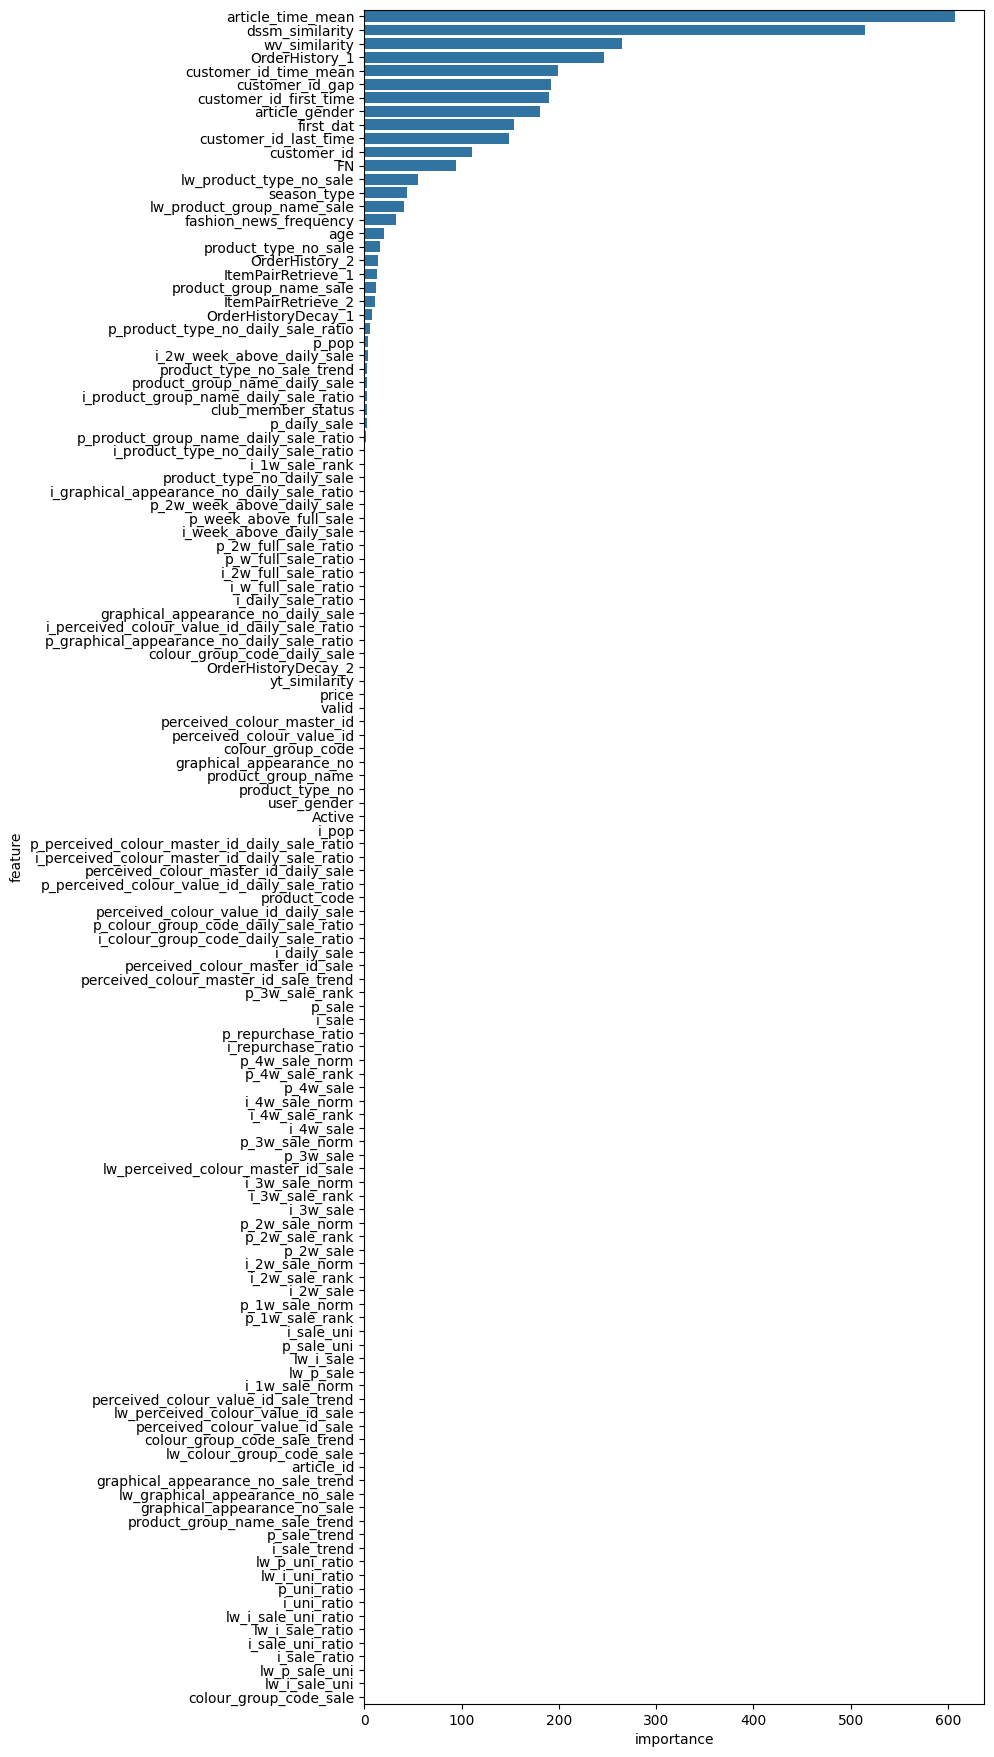

In [66]:
feat_importance = pd.DataFrame(
    {"feature": feats, "importance": ranker.feature_importance()}
).sort_values(by="importance", ascending=False)
plt.figure(figsize=(8, 22))
sns.barplot(y="feature", x="importance", data=feat_importance)

### Validate

In [67]:
val_candidates = valid.reset_index(drop=True)

In [68]:
def predict(ranker, candidates, batch_size = 5_000_000):
    probs = np.zeros(candidates.shape[0])
    for batch in range(0, candidates.shape[0], batch_size):
        outputs = ranker.predict(candidates.loc[batch : batch + batch_size - 1, feats])
        probs[batch : batch + batch_size] = outputs
    candidates["prob"] = probs
    pred_lgb = candidates[['customer_id','article_id','prob']]
    pred_lgb = pred_lgb.sort_values(by=["customer_id","prob"], ascending=False).reset_index(drop=True)
    pred_lgb.rename(columns={'article_id':'prediction'}, inplace=True)
    pred_lgb = pred_lgb.drop_duplicates(['customer_id', 'prediction'], keep='first')
    pred_lgb['customer_id'] = pred_lgb['customer_id'].astype(int)
    pred_lgb = pred_lgb.groupby("customer_id")["prediction"].progress_apply(list).reset_index()
    return pred_lgb

In [69]:
pred = predict(ranker, val_candidates)

  0%|          | 0/111 [00:00<?, ?it/s]

In [70]:
label = labels[1]
label = pd.merge(label, pred, on="customer_id", how="left")

In [71]:
#MapK
map_at_k(label["article_id"], label["prediction"], k=12)

0.015725400725400726

In [72]:
# Recall
recall_at_k(label["article_id"], label["prediction"], k=12)

0.06615081615081615

In [73]:
#HitRate
hr_at_k(label["article_id"], label["prediction"], k=12)

0.14173228346456693

In [74]:
batch_size = 5_000_000
probs = np.zeros(val_candidates.shape[0])
for batch in range(0, val_candidates.shape[0], batch_size):
    outputs = ranker.predict(val_candidates.loc[batch : batch + batch_size - 1, feats])
    probs[batch : batch + batch_size] = outputs
val_candidates["prob"] = probs
pred_lgb = val_candidates[['customer_id','article_id','prob']]
pred_lgb = pred_lgb.sort_values(by=["customer_id","prob"], ascending=False).reset_index(drop=True)
pred_lgb.rename(columns={'article_id':'prediction'}, inplace=True)
pred_lgb = pred_lgb.drop_duplicates(['customer_id', 'prediction'], keep='first')
pred_lgb['customer_id'] = pred_lgb['customer_id'].astype(int)

In [75]:
pred_lgb.to_parquet(data_dir/"processed"/"small_binary_valid.pqt")
# pred_lgb.to_parquet(data_dir/"processed"/"small_rank_valid.pqt")

### Test

In [76]:
# del candidates
# gc.collect()

In [77]:
test_pred = []
for chunk in range(2):
    print(f"Chunk {chunk}")
    test_candidates = pd.read_parquet(data_dir/"processed"/VERSION_NAME/f"week0_candidate_{chunk}.pqt")
    for feat in cat_features:
        test_candidates[feat] = test_candidates[feat].astype(cate_dict[feat])

    # * Extra Features ===================================

    tmp = inter.groupby('article_id').week.mean()
    test_candidates['article_time_mean'] = test_candidates['article_id'].map(tmp)
    # tmp = inter.groupby('article_id').week.mean().reset_index()
    # test_candidates = test_candidates.merge(tmp, on='article_id', how='left')
    # test_candidates.rename(columns={'week': 'article_time_mean'}, inplace=True)

    tmp = inter.groupby('customer_id').week.nth(-1)
    test_candidates['customer_id_last_time'] = test_candidates['customer_id'].map(tmp)

    tmp = inter.groupby('customer_id').week.nth(0)
    test_candidates['customer_id_first_time'] = test_candidates['customer_id'].map(tmp)

    tmp = inter.groupby('customer_id').week.mean()
    test_candidates['customer_id_time_mean'] = test_candidates['customer_id'].map(tmp)

    test_candidates['customer_id_gap'] = test_candidates['customer_id_first_time'] - test_candidates['customer_id_last_time']

    gc.collect()
    # * ==================================================
    
    batch_size = 5_000_000
    # probs = np.zeros(test_candidates.shape[0])
    # for batch in tqdm(range(0, test_candidates.shape[0], batch_size)):
    #     outputs = ranker.predict(test_candidates.loc[batch : batch + batch_size - 1, feats])
    #     probs[batch : batch + batch_size] = outputs
    probs = np.zeros(test_candidates.shape[0])
    for batch in tqdm(range(0, test_candidates.shape[0], batch_size)):
        outputs = ranker.predict(test_candidates.loc[batch:batch + batch_size - 1, feats])
        probs[batch:batch + batch_size] = outputs

    test_candidates["prob"] = probs
    pred_lgb = test_candidates[['customer_id','article_id','prob']]
    pred_lgb = pred_lgb.sort_values(by=["customer_id","prob"], ascending=False).reset_index(drop=True)
    pred_lgb.rename(columns={'article_id':'prediction'}, inplace=True)
    pred_lgb = pred_lgb.drop_duplicates(['customer_id', 'prediction'], keep='first')
    # pred_lgb['customer_id'] = pred_lgb['customer_id'].astype(int)
    test_pred.append(pred_lgb)
    del test_candidates
    gc.collect()

Chunk 0


135

100%|██████████| 1/1 [00:00<00:00, 80.97it/s]


4

Chunk 1


0

100%|██████████| 1/1 [00:00<00:00, 76.70it/s]


4

In [78]:
pred_lgb = pd.concat(test_pred, ignore_index=True)

In [79]:
pred_lgb.to_parquet(data_dir/"processed"/"small_binary_test.pqt")
# pred_lgb.to_parquet(data_dir/"processed"/"small_rank_test.pqt")